<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1374 entries, 2022-01-03 to 2025-11-13
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Lido_APY              1374 non-null   float64
 1   Lido_TVL              1374 non-null   float64
 2   Aave_USDC_APY         1374 non-null   float64
 3   Aave_USDC_TVL         1374 non-null   float64
 4   US_Treasury_10Y       1374 non-null   float64
 5   VIX_Index             1374 non-null   float64
 6   Spread_Aave_Treasury  1374 non-null   float64
 7   Spread_Staking_Risk   1374 non-null   float64
dtypes: float64(8)
memory usage: 96.6 KB
None
            Lido_APY      Lido_TVL  Aave_USDC_APY  Aave_USDC_TVL  \
2022-01-03       3.6  1.107437e+10        1.80182      6884855.0   
2022-01-04       3.6  1.107437e+10        1.80182      6884855.0   
2022-01-05       3.6  1.107437e+10        1.80182      6884855.0   
2022-01-06       3.6  1.107437e+10        1.8018

[]

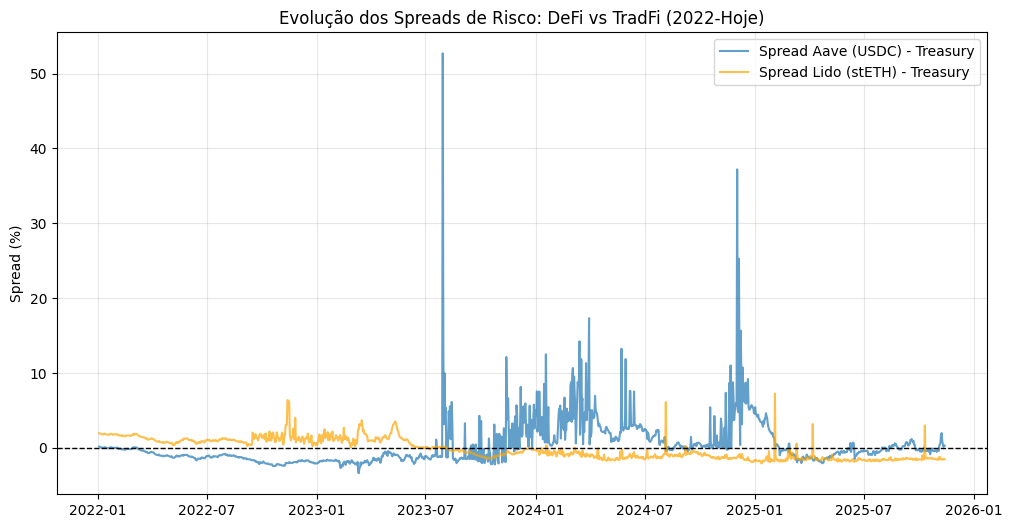

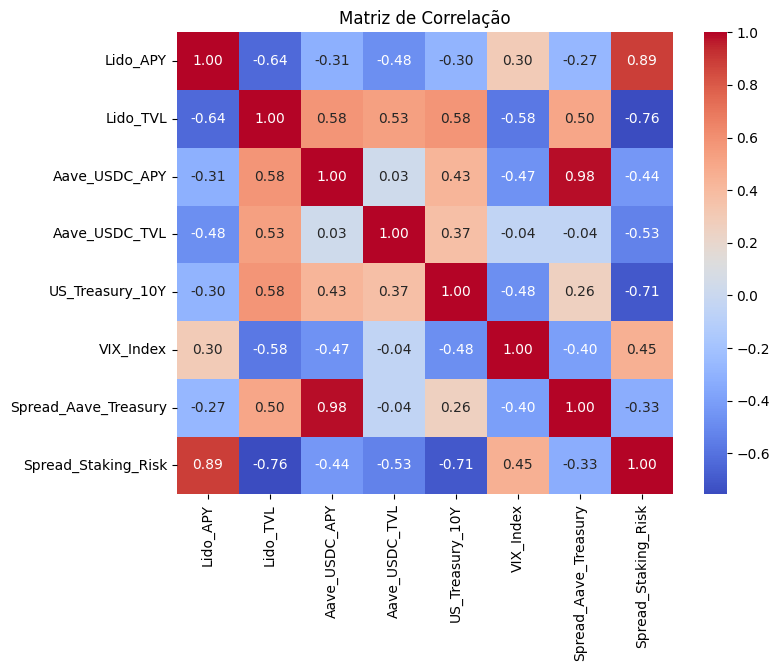

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('dataset_datathon_final.csv', index_col=0, parse_dates=True)

# Display info and first rows
print(df.info())
print(df.head())

# Plotting the Spreads
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Spread_Aave_Treasury'], label='Spread Aave (USDC) - Treasury', alpha=0.7)
plt.plot(df.index, df['Spread_Staking_Risk'], label='Spread Lido (stETH) - Treasury', alpha=0.7, color='orange')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('Evolução dos Spreads de Risco: DeFi vs TradFi (2022-Hoje)')
plt.ylabel('Spread (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('spreads_plot.png')

# Correlation Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação')
plt.plot()

RMSE: 0.3054
Baseline RMSE: 0.2829
Improvement over Baseline: -7.96%
                 Feature  Importance
2  Spread_Rolling_Mean_7    0.630892
3   Spread_Rolling_Std_7    0.146011
0            Spread_Lag1    0.082855
4               VIX_Lag1    0.069309
5          Treasury_Lag1    0.041042
1            Spread_Lag7    0.029891


[]

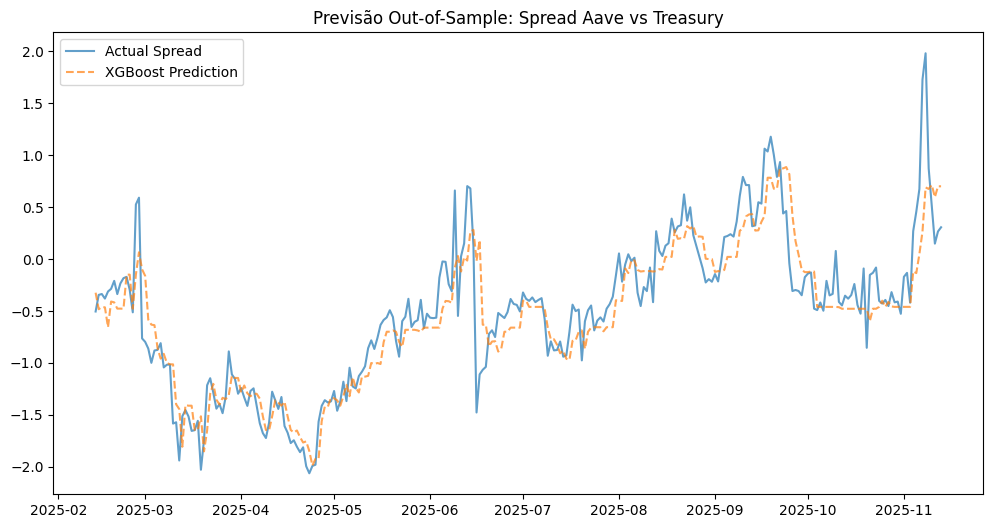

In [6]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

# Feature Engineering
df_model = df.copy()

# Target: Spread_Aave_Treasury
target = 'Spread_Aave_Treasury'

# Create Lags (Autoregressive features)
df_model['Spread_Lag1'] = df_model[target].shift(1)
df_model['Spread_Lag7'] = df_model[target].shift(7)

# Create Rolling Features (Trend/Volatility)
df_model['Spread_Rolling_Mean_7'] = df_model[target].rolling(window=7).mean()
df_model['Spread_Rolling_Std_7'] = df_model[target].rolling(window=7).std()

# External Drivers Lags (VIX, Treasury)
df_model['VIX_Lag1'] = df_model['VIX_Index'].shift(1)
df_model['Treasury_Lag1'] = df_model['US_Treasury_10Y'].shift(1)

# Drop NaNs created by lags
df_model = df_model.dropna()

# Define Features (X) and Target (y)
features = ['Spread_Lag1', 'Spread_Lag7', 'Spread_Rolling_Mean_7', 'Spread_Rolling_Std_7', 'VIX_Lag1', 'Treasury_Lag1']
X = df_model[features]
y = df_model[target]

# Time-based Train/Test Split (80/20)
split_point = int(len(df_model) * 0.8)
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

# Train XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.05, max_depth=5)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.4f}")

# Baseline (Naive Forecast: Predict yesterday's value)
y_pred_naive = X_test['Spread_Lag1']
rmse_naive = np.sqrt(mean_squared_error(y_test, y_pred_naive))
print(f"Baseline RMSE: {rmse_naive:.4f}")

improvement = (rmse_naive - rmse) / rmse_naive * 100
print(f"Improvement over Baseline: {improvement:.2f}%")

# Feature Importance
importance = model.feature_importances_
feat_imp = pd.DataFrame({'Feature': features, 'Importance': importance}).sort_values(by='Importance', ascending=False)
print(feat_imp)

# Plot Predictions vs Actual
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Spread', alpha=0.7)
plt.plot(y_test.index, y_pred, label='XGBoost Prediction', alpha=0.7, linestyle='--')
plt.title('Previsão Out-of-Sample: Spread Aave vs Treasury')
plt.legend()
plt.plot()

In [7]:
print(df[['Spread_Aave_Treasury', 'VIX_Index', 'US_Treasury_10Y']].corr())

                      Spread_Aave_Treasury  VIX_Index  US_Treasury_10Y
Spread_Aave_Treasury              1.000000  -0.403598         0.257292
VIX_Index                        -0.403598   1.000000        -0.475596
US_Treasury_10Y                   0.257292  -0.475596         1.000000


In [8]:
print("Baseline error RMSE:", rmse_naive)
print("XGBoost error RMSE: ", rmse)

Baseline error RMSE: 0.2828945070085438
XGBoost error RMSE:  0.3054063847099775


In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- 5. Modelo 2: Regressão Linear (O "Explicador") ---
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)

# Calcular Erros
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print("Mean Abs Error: ", mae_lr)
print("Mean Sqrt Error: ", rmse_lr)

Mean Abs Error:  0.253088466758869
Mean Sqrt Error:  0.3458541405338189
